In [11]:
#data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from time import time
from operator import itemgetter
# Stop deprecation warnings from being printed
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 1. Problem Definition

We will try to predict as accurately as possible the rating of airbnb rental places based on the set of features available from the airbnb website.

# 2. Acquiring data

In [12]:
df = pd.read_csv('airbnb_mtl_2017.csv')
#df.head()
len(df)

15871

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

# 3. Exploratory analysis

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12696 entries, 14281 to 4556
Data columns (total 19 columns):
room_id                 12696 non-null int64
survey_id               12696 non-null int64
host_id                 12696 non-null int64
room_type               12696 non-null object
country                 0 non-null float64
city                    12696 non-null object
borough                 0 non-null float64
neighborhood            12696 non-null object
reviews                 12696 non-null int64
overall_satisfaction    12696 non-null float64
accommodates            12696 non-null int64
bedrooms                12696 non-null float64
bathrooms               0 non-null float64
price                   12696 non-null float64
minstay                 0 non-null float64
last_modified           12696 non-null object
latitude                12696 non-null float64
longitude               12696 non-null float64
location                12696 non-null object
dtypes: float64(9), int64(

In [15]:
train.describe()

,room_id,survey_id,host_id,country,borough,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,latitude,longitude
count,1.269600e+04,12696.0,1.269600e+04,0.0,0.0,12696.000000,12696.000000,12696.000000,12696.000000,0.0,12696.000000,0.0,12696.000000,12696.000000
mean,1.268306e+07,1556.0,4.242925e+07,NaN,NaN,13.761736,2.742517,3.444943,1.386736,NaN,81.005514,NaN,45.516573,-73.587356
std,6.033145e+06,0.0,4.101708e+07,NaN,NaN,27.331271,2.336893,2.247322,0.951818,NaN,133.575510,NaN,0.028015,0.036790
min,2.078000e+03,1556.0,2.277000e+03,NaN,NaN,0.000000,0.000000,1.000000,0.000000,NaN,8.000000,NaN,45.403320,-73.955358
25%,7.449236e+06,1556.0,9.018586e+06,NaN,NaN,1.000000,0.000000,2.000000,1.000000,NaN,38.000000,NaN,45.500311,-73.601214
50%,1.389192e+07,1556.0,2.824703e+07,NaN,NaN,4.000000,4.500000,3.000000,1.000000,NaN,61.000000,NaN,45.519686,-73.579468
75%,1.835897e+07,1556.0,6.599924e+07,NaN,NaN,14.000000,5.000000,4.000000,2.000000,NaN,97.000000,NaN,45.533479,-73.567170
max,2.036406e+07,1556.0,1.452571e+08,NaN,NaN,384.000000,5.000000,16.000000,13.000000,NaN,8114.000000,NaN,45.698305,-73.481893


In [16]:
train.describe(include=['O'])

,room_type,city,neighborhood,last_modified,location
count,12696,12696,12696,12696,12696
unique,3,1,32,12696,12695
top,Entire home/apt,Montreal,Le Plateau-Mont-Royal,2017-08-10 03:39:09.701193,0101000020E6100000423EE8D9AC6452C08D429259BDC1...
freq,8622,12696,3802,1,2


In [17]:
train.room_type.value_counts()

Entire home/apt    8622
Private room       3962
Shared room         112
Name: room_type, dtype: int64

We can already determine that:
* country, borough, bathrooms and minstay are empty columns that we will delete (1)
* **room_id**, **location** and **host_id** are unique identifying features
* **survey_id** is always 1556.0, **city** is always montreal we will discard them as well (2)

We are not treating this data as a time series, we will therefore **drop last-modified** (3)

We have X numerical variables
* continuous: Price, overall satisfaction
* discrete: host_id, accomodates, reviews

We have Y categorical variables:
* room_type with 3 categories: "Entire home/apt", "Shared room", "Private room"
* neighborhood: 32 of the different neighborhoods in montreal

We will want to rework the geographic information to make it a value we can use with machine learning

### Looking at the review (target) variable

In [18]:
train['overall_satisfaction'].describe()

count    12696.000000
mean         2.742517
std          2.336893
min          0.000000
25%          0.000000
50%          4.500000
75%          5.000000
max          5.000000
Name: overall_satisfaction, dtype: float64

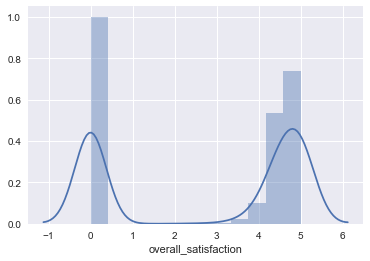

In [19]:
#histogram
sns.distplot(train['overall_satisfaction']);

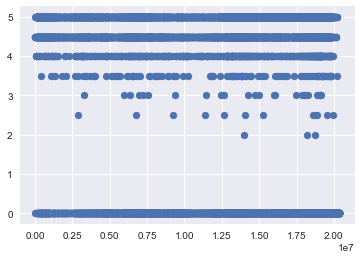

In [20]:
plt.scatter(train['room_id'], train['overall_satisfaction']);
plt.show()

It is important to note that most of the 0 reviews come from listings that were not rated, therefore we will drop all the listing that were not rated from the sample (4)

In [21]:
train.overall_satisfaction.value_counts()

0.0    5294
5.0    3902
4.5    2826
4.0     524
3.5     110
3.0      25
2.5      12
2.0       3
Name: overall_satisfaction, dtype: int64

It is however intriguing that so many of the ratings are above 3 and virtually none them is between 1 and 3. After further research and comparing with other airbnb datasets, in turns out it is a recurrent problem in airbnb ratings, a disproportionate amount of the ratings is above 4.5, it could be interesting to look at how ratings are computed and further inquire that review system that seems fairly flawed. For now we will try to see if we can obtain a good accuracy in predicting them anyways.

In [22]:
train.host_id.value_counts().head()

12243051    115
778430       44
38459934     39
15935760     25
318040       24
Name: host_id, dtype: int64

some host have several postings, we could create a new feature linking of the number of postings of the owner to each room, to see if the experience of a host correlates with the quality of the rankings

# 4. Feature engineering and modification

In [23]:
#dropping the dicussed columns
df = df.drop(["country","survey_id","last_modified","city","borough","bathrooms","minstay"], axis=1)


In [24]:
train.reviews.value_counts().head()

0    2818
1    1406
2    1065
3     792
4     664
Name: reviews, dtype: int64

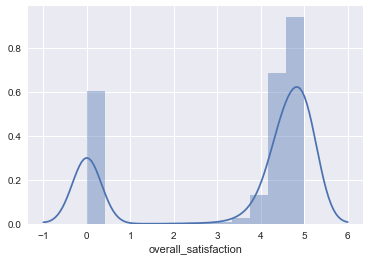

In [25]:
#Dropping 0 columns
df = df[df.reviews != 0]

sns.distplot(df['overall_satisfaction']);

In [26]:
revs = train.reviews.value_counts()
df[df["overall_satisfaction"]  == 0];

There is still a significant number of 0 ratings. Part of the reason is the fact that people who review do not HAVE to leave a ratings, they CAN leave a rating in addition to their review. That adds an interesting component to our prediction since most of those 0 ratings are due to the fact that people did not rate the appartment. We could either discard them assuming that is the case, or keep the ratings, technically we are still solving the same question of "What will the rating" be, however there is a new dimension to it: "Will there be a rating ?" We unfortunately cannot clearly separate both here without making some really strong assumptions so we will see how our predictive models perform with the 0 ratings in the set.

In [27]:
train.head()

,room_id,survey_id,host_id,room_type,country,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,last_modified,latitude,longitude,location
14281,12848478,1556,33248590,Private room,NaN,Montreal,NaN,Le Plateau-Mont-Royal,1,0.0,1,1.0,NaN,29.0,NaN,2017-08-10 01:41:15.884102,45.507047,-73.574295,0101000020E610000068D0D03FC16452C0784485EAE6C0...
902,18947586,1556,83787111,Entire home/apt,NaN,Montreal,NaN,Côte-des-Neiges-Notre-Dame-de-Grâce,1,0.0,6,2.0,NaN,182.0,NaN,2017-08-10 09:27:25.784026,45.465022,-73.629602,0101000020E6100000C2DF2F664B6852C0D3F544D785BB...
1575,18064458,1556,18162251,Entire home/apt,NaN,Montreal,NaN,Ville-Marie,11,5.0,8,1.0,NaN,185.0,NaN,2017-08-10 09:18:55.194402,45.508896,-73.552832,0101000020E6100000AA0B7899616352C059880E8123C1...
7941,8048456,1556,7274602,Entire home/apt,NaN,Montreal,NaN,Le Sud-Ouest,52,5.0,2,0.0,NaN,55.0,NaN,2017-08-10 04:48:23.775130,45.483288,-73.575692,0101000020E610000068244223D86452C04E469561DCBD...
3651,4823308,1556,24836220,Entire home/apt,NaN,Montreal,NaN,Ville-Marie,0,0.0,2,1.0,NaN,102.0,NaN,2017-08-10 07:39:30.948337,45.516323,-73.556667,0101000020E6100000CCF09F6EA06352C018963FDF16C2...


We now need to encode the categorical variables for neighborhood and room_type. Since none of these is ordinal, we will use one hot encoding. (5)

In this first attempt, we will use latitude and longitude to calculate the distance between each place and the heart of downtown montreal, that we will arbitrarily define as the middle of the postal code polygon corresponding to it, situated approximately at 45.505369, -73.566107.

Let us now add a column corresponding to that distance  for each record, using the geopy plugin to compute the distance between two points

In [28]:
from geopy.distance import vincenty
downtown_mtl = (45.505369, -73.566107)
#cleveland_oh = (41.499498, -81.695391)
#print(vincenty(downtown_mtl, cleveland_oh).miles)

#the vincenty function uses the vincenty formula to compute the distance between two points defined by their
#latitude and longitude
df['downtown_dist'] = df.apply (lambda row: vincenty((row['latitude'], row['longitude']), downtown_mtl).kilometers,axis=1)


In [29]:
df.head()

,room_id,host_id,room_type,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude,location,downtown_dist
0,15023220,90096724,Shared room,Rosemont-La Petite-Patrie,4,5.0,1,1.0,52.0,45.544091,-73.594396,0101000020E6100000E33785950A6652C023861DC6A4C5...,4.837937
1,1132103,4162573,Shared room,Ville-Marie,20,5.0,1,1.0,53.0,45.506773,-73.568754,0101000020E6100000075E2D77666452C077BF0AF0DDC0...,0.259116
4,7067433,36987539,Shared room,Verdun,5,5.0,2,1.0,14.0,45.458891,-73.571854,0101000020E61000008E058541996452C0E1B6B6F0BCBA...,5.185125
5,13274638,20707779,Shared room,Rosemont-La Petite-Patrie,2,0.0,2,1.0,20.0,45.547610,-73.574754,0101000020E6100000B14F00C5C86452C0357BA01518C6...,4.743102
6,12851518,70209623,Shared room,Rosemont-La Petite-Patrie,1,0.0,1,1.0,12.0,45.551003,-73.575831,0101000020E61000007841446ADA6452C0BB7F2C4487C6...,5.128429


We will for now get rid of the latitude longitude and location string.

In [30]:
df.drop(["latitude", "longitude", "location"], axis = 1, inplace=True)


Let us now perform one hot encoding using the pandas get dummies functions

In [31]:
df = pd.get_dummies(df)

# 5. Model Building

We will now split our data into a train and test set and more closely look at the correlations

Let us first try to handle the outputs as a continuous variable. If that does that not work well, we will consider handling them as discrete numerical values, since the possible more scores are from 0.0 to 5.0 with .5 increments.

This is not working at all, why ? because we are checking for exact values while using a continuous variable, we could either add an interval of confidence or turn towards classification models.

In [32]:
#Converting integers to floats in order to be able to handle them as categorical variables
df['overall_satisfaction'] = df['overall_satisfaction'].apply(lambda x: int(x))

In [33]:
#Perform the split again, this time on the modified data
from sklearn.model_selection import train_test_split
train2, test2 = train_test_split(df, test_size=0.2)


#Preparing and splitting our sets into development and evaluation
X_train = train2.drop("overall_satisfaction", axis=1)
y_train = train2.overall_satisfaction.values

X_test = test2.drop("overall_satisfaction", axis=1)
y_test = test2.overall_satisfaction.values

In [34]:
X_test

,room_id,host_id,reviews,accommodates,bedrooms,price,downtown_dist,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,...,neighborhood_Pointe-Claire,neighborhood_Rivière-des-Prairies-Pointe-aux-Trembles,neighborhood_Rosemont-La Petite-Patrie,neighborhood_Saint-Laurent,neighborhood_Saint-Léonard,neighborhood_Sainte-Anne-de-Bellevue,neighborhood_Verdun,neighborhood_Ville-Marie,neighborhood_Villeray-Saint-Michel-Parc-Extension,neighborhood_Westmount
905,13712533,57553561,5,4,2.0,178.0,3.747364,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4116,16779255,50926937,8,9,0.0,102.0,1.662640,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5181,13466838,77010936,21,4,2.0,65.0,4.834290,1,0,0,...,0,0,0,0,0,0,1,0,0,0
5596,5942764,30838244,168,5,2.0,81.0,1.825877,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5996,13357211,9860561,7,5,3.0,77.0,4.922448,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3916,13182470,50275852,44,2,2.0,88.0,1.602785,1,0,0,...,0,0,0,0,0,0,0,1,0,0
7084,9757981,16187198,1,5,3.0,80.0,4.622066,1,0,0,...,0,0,1,0,0,0,0,0,0,0
11271,3773423,19343242,19,1,1.0,48.0,1.271244,0,1,0,...,0,0,0,0,0,0,0,1,0,0
10791,18565331,16214314,3,2,1.0,114.0,1.377321,0,1,0,...,0,0,0,0,0,0,0,1,0,0
8091,18583293,106943829,6,4,1.0,56.0,1.343602,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

from sklearn.model_selection import cross_val_score

#Performing a 10-fold cross validation
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

#Note: "Too many indices in array" error raised whenever Y is a pandas df instead of a numpy array.
#Note2: X being a df does not seem to be a problem.

[ 0.39292929  0.39635996  0.3937247   0.39452333  0.39452333  0.39452333
  0.39553753  0.39553753  0.39350913  0.39492386]
0.394609196492


Expand: natural language processing

In [36]:
#KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors = 3)
##knn.fit(train_X, train_y)
##pred_y = knn.predict(test_X)

scores = cross_val_score(KNN, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.39292929  0.36602629  0.37651822  0.39655172  0.38843813  0.38742394
  0.37525355  0.38235294  0.37829615  0.38274112]
0.382653134751


In [37]:
# Gaussian Naive Bayes

GS = GaussianNB()
#gaussian.fit(train_X, train_y)
#pred_y = gaussian.predict(test_X)


scores = cross_val_score(GS, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.39494949  0.37411527  0.38157895  0.40365112  0.38032454  0.39655172
  0.40162272  0.39655172  0.38133874  0.36954315]
0.388022742542


In [38]:
# Perceptron

pcp = Perceptron()
#perceptron.fit(train_X, train_y)
#pred_y = perceptron.predict(test_X)


scores = cross_val_score(pcp, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.39090909  0.33771486  0.28441296  0.39350913  0.39959432  0.39452333
  0.39452333  0.39452333  0.39148073  0.38883249]
0.37700235554


In [39]:
# Random Forest

RDF = RandomForestClassifier(n_estimators=100)
#random_forest.fit(train_X, train_y)
#pred_y = random_forest.predict(test_X)


scores = cross_val_score(RDF, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.71616162  0.68250758  0.69534413  0.70182556  0.71095335  0.70791075
  0.72210953  0.69675456  0.69776876  0.70862944]
0.703996528597


In [40]:
# Stochastic Gradient Descent

SGD = SGDClassifier()
#sgd.fit(train_X, train_y)
#pred_y = sgd.predict(test_X)

scores = cross_val_score(SGD, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.23636364  0.25884732  0.23684211  0.35294118  0.33772819  0.40263692
  0.26369168  0.39452333  0.2535497   0.39898477]
0.313610882764


In [41]:
# Decision Tree

DCT = DecisionTreeClassifier()

#decision_tree.fit(train_X, train_y)
#pred_y = decision_tree.predict(test_X)


scores = cross_val_score(DCT, X_train, y_train, cv=10)
print(scores)
print(scores.mean())

[ 0.64848485  0.64509606  0.66093117  0.63894523  0.64198783  0.65314402
  0.663286    0.6643002   0.63184584  0.67411168]
0.652213288211


It appears that Decision Tree and Random Forest perform way better than the others. We will therefore focus on tuning random forest in order to increase the accuracy of our model.

## 5.2 Model Tuning

Let us use gridsearch to tune the parameters of our random forest

In [42]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

Now let us use our fresh parameters on our test set and see what we get 

In [43]:
train2.head()

,room_id,host_id,reviews,overall_satisfaction,accommodates,bedrooms,price,downtown_dist,room_type_Entire home/apt,room_type_Private room,...,neighborhood_Pointe-Claire,neighborhood_Rivière-des-Prairies-Pointe-aux-Trembles,neighborhood_Rosemont-La Petite-Patrie,neighborhood_Saint-Laurent,neighborhood_Saint-Léonard,neighborhood_Sainte-Anne-de-Bellevue,neighborhood_Verdun,neighborhood_Ville-Marie,neighborhood_Villeray-Saint-Michel-Parc-Extension,neighborhood_Westmount
11786,20186930,21877781,1,0,2,0.0,44.0,2.719207,0,1,...,0,0,0,0,0,0,0,1,0,0
2710,19662621,81175099,6,4,6,2.0,122.0,0.862957,1,0,...,0,0,0,0,0,0,0,1,0,0
12537,13620125,78872473,10,5,2,1.0,25.0,4.224474,0,1,...,0,0,0,0,0,0,0,0,0,0
14520,19695215,58290304,3,5,2,1.0,38.0,1.901366,0,1,...,0,0,0,0,0,0,0,0,0,0
13730,19608886,53331849,1,0,2,1.0,29.0,5.269251,0,1,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# calculate the time to run a GridSearchCV for multiple numbers of parameter permutations.  
grid_times = {}
clf = RandomForestClassifier(random_state = 84)

features = X_train.columns.drop(['room_id'], 1)


# I commented this out after running once locally since this block of code takes a long time to run
'''
grid_1 = { "n_estimators"      : [500],
               "criterion"         : ["gini", "entropy"],
               "max_features"      : ['sqrt','log2',0.5,],
         }

grid_search = GridSearchCV(clf, grid_1, n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train)
'''
#grid_search.best_score = .71

'\ngrid_1 = { "n_estimators"      : [500],\n               "criterion"         : ["gini", "entropy"],\n               "max_features"      : [\'sqrt\',\'log2\',0.5,],\n         }\n\ngrid_search = GridSearchCV(clf, grid_1, n_jobs=-1, cv=5)\ngrid_search.fit(X_train, y_train)\n'

No substantial improvement from for gridsearch, a more thorough analysis using an AWS server for more
computing power to tune this will maybe lead us to better results, we will stay here for now and look at
where the errors are

### Back to features ,let us look at where our model makes most errors

In [45]:
#grid_search.best_params_ {'criterion': 'gini', 'max_features': 0.5, 'n_estimators': 500}

In [48]:
clf = RandomForestClassifier( 
                             n_estimators = 500, 
                             max_features = 0.5,
                             criterion = 'gini')

clf.fit(X_train, y_train);
prediction = clf.predict(X_test)

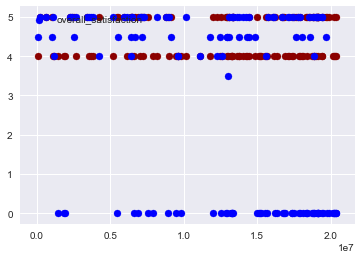

In [58]:
correct_idx = np.where(prediction == y_test)[0]

incorrect_idx = np.where(prediction != y_test)[0]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(test['room_id'][incorrect_idx], prediction[incorrect_idx], color="darkred")
ax1.scatter(test['room_id'][incorrect_idx], test.overall_satisfaction[incorrect_idx], color="blue")
plt.legend(loc='upper left');
plt.show()

The nexts steps will be to further tune the model and try to raise the accuracy of 71% on the test set, we could then extend it to data from other cities in order to make it more general